In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import random
import csv
from datetime import datetime
import time
import json

from langchain.schema.runnable import RunnableSequence

In [2]:
# Do imports for deh experiments specific modules
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

utils_folder = Path(".")
sys.path.append(str(utils_folder))

import deh_globals
globals().update(deh_globals.__dict__)
import squad_scoring
globals().update(deh_globals.__dict__)
import deh_prompts
import deh_vector_store
globals().update(deh_vector_store.__dict__)
import deh_squad_data
import deh_hyde
import deh_experiments_config
globals().update(deh_experiments_config.__dict__)
import deh_llm
globals().update(deh_llm.__dict__)

In [3]:
## Set global parameters depending on the current experiment

# experiments["P1_F1_K8"] = {
#     "name": "P1_F1_K8",
#     "title": "P1_F1_K8",
#     "sample_ldicts_idx": SAMPLE_LDICTS_IDX,
#     "query_prompt_idx": BASIC_RAG_PROMPT_IDX,
#     "context_needed": True,
#     "hyde_context_needed": False,
#     "suppress_answers": False,
#     "chunking_method": "naive",
#     "llm_model": "llama3.1",
#     "temperature": 0.5
# }

EXPERIMENT_GLOBAL_ID = current_experiment["name"]
DEFAULT_CHUNKING_METHOD = current_experiment["chunking_method"]
CHAT_MODEL_NAME = current_experiment["llm_model"]
TEMPERATURE = current_experiment["temperature"]
VECTOR_STORE_TOP_K = current_experiment["vector_store_top_k"]


##### Loading SQuAD data

In [4]:
# csv_file_path = f"{DATA_ROOT}/qas_with_contexts_hello.csv"

print(f"Loading squad data...\n")

column_names = ["title", "squad_context", "qid", "question", "is_impossible", "answer"]

try:
    squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv", names=column_names, skiprows=1)
    print(f"Loaded squad data from {DATA_ROOT}/squad_raw.csv")
except:
    print(f"Failed to load squad data from {DATA_ROOT}/squad_raw.csv")

df_squad_raw = pd.DataFrame(squad_raw)
print(f"Number of raw entries in squad_raw: {len(df_squad_raw)}")

df_titles = pd.DataFrame(df_squad_raw['title'].unique(), columns=["title"])
print(f"Number of unique titles: {len(df_titles)}")

df_contexts = pd.DataFrame(df_squad_raw['squad_context'].unique(), columns=["squad_context"])
print(f"Number of unique contexts: {len(df_contexts)}")

df_qas = df_squad_raw[['title', 'squad_context', 'qid', 'question', 'is_impossible']].drop_duplicates()
df_qas = df_qas.reset_index(drop=True)
print(f"Number of unique questions: {len(df_qas)}")

df_squad_answers = df_squad_raw[['qid', 'question', 'answer']].drop_duplicates()
print(f"Number of unique answers: {len(df_squad_answers)}")           
            

Loading squad data...

Loaded squad data from ../../../deh_data_results/data/squad_raw.csv
Number of raw entries in squad_raw: 26232
Number of unique titles: 35
Number of unique contexts: 1204
Number of unique questions: 11858
Number of unique answers: 16209


In [5]:
# my_l = df_contexts.values.tolist()
# my_l2 = [len(ctx[0]) for ctx in my_l]
# my_l2 = sorted(my_l2)
# len([ctx for ctx in my_l2 if ctx > 1500])
    

# #sorted(my_l2)[-100:]#

##### Intialize the Vector Store (Chroma; Milvus not yet included); if configured, re-chunk the data

In [6]:
contexts = list(df_contexts["squad_context"].values)
if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHUNKING_METHOD)

Chunking not foreseen. Skipping chunking.
Will now get the following vector store: ../../../deh_data_results/chroma/chroma/chroma_deh_rag_db_k5_cs1000_naive


##### Loading qas with contexts data (if data is not to be restored)

In [7]:
def load_qas_with_contexts_from_file(chunking_method):
    
    file_path = f"{DATA_ROOT}/qas_with_contexts_k{VECTOR_STORE_TOP_K}_cs{CHUNK_SIZE}_{chunking_method}.csv"
    print(f"Loading qas_with_contexts from the CSV file: {file_path}\n...")
    
    try:
        df_qas_with_contexts = pd.read_csv(file_path) #, names=column_names)
        print(f"Loaded qas_with_contexts from {file_path}\n...")
    except Exception as e:  # Catch all exceptions
        print(f"An error has occurred: {e}")
        print(f"Failed to load qas_with_contexts from {file_path}")
        sys.exit(1)

    # drop the answer column if it exists, since it leads to duplicates
    if 'answer' in df_qas_with_contexts.columns:
        df_qas_with_contexts = df_qas_with_contexts.drop(columns=['answer'])

    df_qas_with_contexts = df_qas_with_contexts.drop_duplicates()

    print(f"Rows in dataframe df_qas_with_contexts: {len(df_qas_with_contexts)}")
    
    hyde_articles_cnt = df_qas_with_contexts['hyde_article'].notna().sum()
    hyde_based_contexts_cnt = df_qas_with_contexts['hyde_based_context'].notna().sum()
    print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
    print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

    return df_qas_with_contexts

In [8]:


# If not restoring qas_with_contexts from the CSV file, then read
# the data from the csv file (i.e. it exists and is correct)
if not RESTORE_QAS_WITH_CONTEXTS:
    df_qas_with_contexts = load_qas_with_contexts_from_file(DEFAULT_CHUNKING_METHOD)
    df_qas_with_contexts_semantic = load_qas_with_contexts_from_file(DEFAULT_SEMANTIC_CHUNKING_METHOD)
else:
    print(f"RESTORE_QAS_WITH_CONTEXTS is True. Skipping loading qas_with_contexts from the CSV file.")



Loading qas_with_contexts from the CSV file: ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Loaded qas_with_contexts from ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Rows in dataframe df_qas_with_contexts: 11858
Number of questions with Hyde articles: 3918
Number of questions with Hyde based contexts: 3918
Loading qas_with_contexts from the CSV file: ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Loaded qas_with_contexts from ../../../deh_data_results/data/qas_with_contexts_k5_cs1000_naive.csv
...
Rows in dataframe df_qas_with_contexts: 11858
Number of questions with Hyde articles: 3918
Number of questions with Hyde based contexts: 3918


##### Restore qas with contexts (if configured); alternatively refreseh contexts in existing file

In [9]:
# Only used for restoring the qas_with_contexts, should it be corrupted
# Normally, this should not be frequently needed
def restore_df_qas_with_contexts_file(file_path, df_qas):

    # Add columns hyde_article, question_context, hyde_based_context to df_qas_with_contexts
    if not 'hyde_article' in df_qas.columns:
        df_qas['hyde_article'] = np.nan
    if not 'question_context' in df_qas.columns:
        df_qas['question_context'] = np.nan
    if not 'hyde_based_context' in df_qas.columns:
        df_qas['hyde_based_context'] = np.nan

    # Get Hyde data
    hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
    df_hyde_based_contexts = pd.read_csv(hyde_based_context_path)

    print(f"Rows in dataframe df_hyde_based_contexts: {len(df_hyde_based_contexts)}")
    hyde_articles_cnt = df_hyde_based_contexts['hyde_article'].notna().sum()
    hyde_based_contexts_cnt = df_hyde_based_contexts['hyde_based_context'].notna().sum()

    # Merge df_qas with df_hyde_based_contexts based on the 'qid' column
    merged = df_qas.merge(df_hyde_based_contexts, on='qid', how='left', suffixes=('', '_df_hyde_based_contexts'))
    df_qas['hyde_article'] = merged['hyde_article_df_hyde_based_contexts']

    print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
    print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

    df_qas.to_csv(file_path, header=True, index=False)


In [10]:
# TODO --> check if qas_with_contexts file already exists
# The following is only needed if the qas_with_contexts file is corrupted
# or if the contexts need to be refreshed for any reason

#for VECTOR_STORE_TOP_K in [3, 5, 6, 8, 12]:
if RESTORE_QAS_WITH_CONTEXTS:
    restore_file_path = f"{DATA_ROOT}/qas_with_contexts_k{VECTOR_STORE_TOP_K}_cs{CHUNK_SIZE}_{DEFAULT_CHUNKING_METHOD}.csv"
    restore_df_qas_with_contexts_file(restore_file_path, df_qas)

# Refresh question contexts (normal contexts and hyde-based contexts)
# TODO: might be useful to first empty the two columns in the dataframe
if RESTORE_QAS_WITH_CONTEXTS or REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Re-Generating contexts for the dataset and persisting the data...")
    list_of_qas = df_qas.to_dict(orient='records')

    for i, qa in enumerate(list_of_qas):
        # print(i)
        if i %100 == 0:
            print(f"Processing question {i}...")

        if RESTORE_QAS_WITH_CONTEXTS or REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = "\n\n".join([top_doc.page_content for top_doc in top_docs])

        if RESTORE_QAS_WITH_CONTEXTS or REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            #print(f"hyde_article: {hyde_article}")
            if pd.isna(hyde_article):
                hyde_article = ""
            elif len(hyde_article) == 0:
                hyde_article = ""
            else:
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = "\n\n".join([top_doc.page_content for top_doc in top_docs])

    df_qas = pd.DataFrame(list_of_qas)
    df_qas_with_contexts = df_qas.copy()
    df_qas.to_csv(restore_file_path, header=True, index=False)
else:
    print(f"Not restoring df_qas_with_contexts or refresh of the contexts...")

Not restoring df_qas_with_contexts or refresh of the contexts...


In [11]:
# dir(vector_store)

##### Show names of all dataframes

In [12]:
import copy 

print("Names of Dataframes and their lenghts:\n")
global_keys_copy = copy.deepcopy(list(globals().keys()))

my_l = [{n: len(globals()[n])} for n in global_keys_copy if n.startswith("df_")]
df_dfs = pd.DataFrame([(k, v) for d in my_l for k, v in d.items()], columns=['df name', 'rows'])
df_dfs


Names of Dataframes and their lenghts:



,df name,rows
0,df_experiments,3
1,df_squad_raw,26232
2,df_titles,35
3,df_contexts,1204
4,df_qas,11858
5,df_squad_answers,16209
6,df_qas_with_contexts,11858
7,df_qas_with_contexts_semantic,11858


##### Define functions that are needed for experiments

In [13]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [14]:
# Get the Hyde context for a question
def get_hyde_based_context(question):
    hyde_based_context = df_qas_with_contexts[df_qas_with_contexts["question"] == question]
    if hyde_based_context.empty:
        return None
    else:
        return hyde_based_context["hyde_based_context"].values[0]
    

In [15]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [16]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (max(mean - margin_of_error, 0), min(mean + margin_of_error, 100))

    return mean, ci

In [17]:
# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)

    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N:,} - Sample Size: {SAMPLE_SIZE:,})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    max_len = 6
    mean_label = f"{mean: .2f}".rjust(max_len)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1:          {mean_label}')

    # Add vertical lines for the 95% confidence interval
    lower = f"{ci[0]: .2f}".rjust(max_len)
    upper = f"{ci[1]: .2f}".rjust(max_len)
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Lower:  {lower}")
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Upper:  {upper}\n")

    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Set major ticks every 10 units
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # Set minor ticks every 5 units
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # Customize grid for major and minor ticks
    ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)

    # Add a legend

    # Add additional text to the legend
    from matplotlib.lines import Line2D

    handles, labels = ax.get_legend_handles_labels()
    model_info_line = Line2D([0], [0], color='none', label=f"LLM Model: {CHAT_MODEL_NAME}")
    handles.append(model_info_line)
    labels.append(f"LLM Model: {CHAT_MODEL_NAME}")
    handles.append(model_info_line)
    labels.append(f"max_tokens={MAX_TOKENS:,}")
    handles.append(model_info_line)
    labels.append(f"chunk_size={f"{CHUNK_SIZE:,}"}")
    handles.append(model_info_line) 
    if experiment_name == "BASIC_RAG_SEMANTIC_CHUNKGING":
        labels.append(f"K={VECTOR_STORE_TOP_K} / {DEFAULT_SEMANTIC_CHUNKING_METHOD}")
    else:
        labels.append(f"K={VECTOR_STORE_TOP_K} / {DEFAULT_CHUNKING_METHOD}")

    # TODO: Clean this code
    plt.legend(prop={'family': 'monospace', 'size': 9})
    plt.legend(handles, labels, loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))
    return plt

##### LLM as a Judge functions

In [18]:
def convert_string_to_answer_tuple(input_string):
    # Trim whitespace
    parts = input_string.strip()
    # Remove parentheses
    parts = parts.strip("()")
    # Split on comma
    parts = parts.split(", ")
    if len(parts) != 2:
        return ("NO", 0)

    answer = parts[0].strip().upper()  # "Yes" or "No"
    if answer not in ["YES", "NO"]:
        return ("NO", 0)
    try:
        score = float(parts[1])  # Convert score to a float
    except ValueError:
        return ("NO", 0)
    
    return (answer, score)

In [19]:
def get_majority_verdict(judge_verdicts):

    judge_answers = judge_verdicts[0]
    yes_count = judge_answers.count('YES')
    no_count = judge_answers.count('NO')

    if no_count > yes_count:
        return "NO", 0.0
    
    judge_scores = list(judge_verdicts[1])
    return "YES", sum(judge_scores) / yes_count

def get_majority_verditcs(all_judge_answers, all_judge_scores):

    majority_verdicts = []
    for per_question_judge_verdicts in zip(zip(*all_judge_answers), zip(*all_judge_scores)):
        majority_verdict = get_majority_verdict(per_question_judge_verdicts)
        majority_verdicts.append(majority_verdict)

    return majority_verdicts


In [20]:
def get_final_judges_verdicts(sample_ldict, experiment_name, hyde_context_needed=False):
    judge_current_query_prompt = deh_prompts.query_prompts[4]
    print(f"judge_current_query_prompt = {judge_current_query_prompt.template}\n")
    for ele in sample_ldict:
        print(ele)
        print("\n")

    all_judge_answers = []
    all_judge_scores = []

    print("--------------------------------------------------------")
    for judge_i, judge_llm in enumerate(judge_llms):
        judge_chain = judge_current_query_prompt | get_llm(judge_current_query_prompt, True, judge_llm)
        judge_answers = []
        judge_scores = []

        for i, qa in enumerate(sample_ldict):

            if i % 10 == 0:
                print(f"Processing question {i} for judge {judge_i}...")

            question = qa["question"]
            context = qa["question_context"]
            if hyde_context_needed:
                hyde_based_context = qa["hyde_based_context"]
                context = "\n\n".join([context, hyde_based_context])
            answer_key = experiment_name.lower() + "_llm_answer"
            answer = qa[answer_key]

            response = judge_chain.invoke({"context": context, "question": question, "answer": answer})
            a, s = convert_string_to_answer_tuple(response.content)
            judge_answers.append(a)
            judge_scores.append(s)
            
        all_judge_answers.append(judge_answers)
        all_judge_scores.append(judge_scores)

    final_judges_verdicts = get_majority_verditcs(all_judge_answers, all_judge_scores)
    return final_judges_verdicts

##### Define functions for Bootstrapping

In [21]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [22]:
def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False,
                     hyde_based_context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    # add each answer to the all_preds
    preds = {}
    all_preds= {}

    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed or hyde_based_context_needed:
            if not hyde_based_context_needed:
                context = qa["question_context"]
            elif not context_needed:
                context = qa["hyde_based_context"]
            else:
                context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]

            # if experiment_name in ["BASIC_RAG_HYDE"]:
            #     context = qa["hyde_based_context"]
            # elif experiment_name in ["FULL_RAG"]:
            #     context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]
            # elif experiment_name in ["BASIC_RAG", "BASIC_RAG_DONT_LIE",
            #                          "BASIC_RAG_SUPPRESS_ANSWERS", "BASIC_RAG_SEMANTIC_CHUNKING"]:
            #     context = qa["question_context"]
            # print(f"Context case 1: {context}")
            response = runnable_chain.invoke({"question": question, "context": context})
        elif hyde_based_context_needed:
            context = qa["hyde_based_context"]
            # print(f"Context case 2: {context}")
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        # print(f"Question: {question}")
        # print(f"the context was ---> {context}")
        # print(f" end of context -------------------------------------\n\n")

        llm_answer = response.content

        if "DONT KNOW" in llm_answer.upper() or llm_answer.upper().startswith("NO CONTEXT PROVIDED") or llm_answer.upper().startswith("NO INFORMATION GIVEN"): # or llm_answer.upper().startswith("UNFORTUNATELY"):     
            llm_answer = ""

        preds[qid] = llm_answer
        all_preds[qid] = llm_answer

        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall

    if suppress_answers:
        final_judges_verdicts = get_final_judges_verdicts(qas, experiment_name, hyde_context_needed)
        for i, qa in enumerate(qas):
            if final_judges_verdicts[i][0] == "NO":
                qa[f"{experiment_name.lower()}_llm_answer"] = ""
            else:
                if final_judges_verdicts[i][1] < JUDGES_SUPPRESS_THRESHOLD:
                    qa[f"{experiment_name.lower()}_llm_answer"] = ""

    return all_preds
        

In [23]:
def persist_results(results_folder_name, experiment_name, df, eval_dict):

    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)
    df[['qid', 'question', f"{experiment_name.lower()}_llm_answer"]].to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_answers.csv", header=True, index=False)
   
    json_file_name = f"{results_folder_name}/qas_{experiment_name.lower()}_answers.json"
    df_json = df[['qid', f"{experiment_name.lower()}_llm_answer"]].rename(columns={f"{experiment_name.lower()}_llm_answer": "answer"})
    answer_data = {row["qid"]: row["answer"] for _, row in df_json.iterrows()}
    with open(json_file_name, "w") as json_file:
        json.dump(answer_data, json_file, indent=4)

    eval_dict_file_name = f"{results_folder_name}/eval_dict_{experiment_name.lower()}.json"
    eval_data = {key: round(value, 2) for key, value in eval_dict.items()}
    with open(eval_dict_file_name, "w") as json_file:
        json.dump(eval_data, json_file, indent=4)
    

In [24]:
def persist_experiments_config(results_folder_name, experiment_name, query_prompt_idx, 
                               experiment_mean, experiment_ci, execution_time):

    params_str = f"Experiment: {experiment_name}\n"
    params_str = params_str + f"{datetime.now()}\n"
    params_str = params_str + f"Execution duration in minutes: {round(execution_time/60,2)}\n"
    params_str = params_str + "================================================\n\n"

    current_query_prompt_str = deh_prompts.query_prompts[query_prompt_idx].template
#    print(f"current_query_prompt = {current_query_prompt.template}\n")
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + "Prompt used:\n"
    params_str = params_str + current_query_prompt_str + "\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"LLM: {CHAT_MODEL_NAME}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"F1 mean: {round(experiment_mean, 2)}\n"
    params_str = params_str + f"95% CI ({round(experiment_ci[0], 2)}, {round(experiment_ci[1],2)})\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"DATA_ROOT = {DATA_ROOT}\n"
    params_str = params_str + f"RESULTS_ROOT = {RESULTS_ROOT}\n"
    params_str = params_str + f"HYDE_BASED_CONTEXTS_ROOT  = {HYDE_BASED_CONTEXTS_ROOT}\n"
    params_str = params_str + f"data_file = {DATA_ROOT}/dev-v2.0.json\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"CHROMA_ROOT               = {CHROMA_ROOT}\n"
    params_str = params_str + f"VECTOR_STORE_TOP_K        = {VECTOR_STORE_TOP_K}\n"
    params_str = params_str + f"CHUNK_SIZE                = {CHUNK_SIZE}\n"
    params_str = params_str + f"CHUNK_OVERLAP             = {CHUNK_OVERLAP}\n"
    params_str = params_str + f"DEFAULT_CHROMA_PREFIX     = {DEFAULT_CHROMA_PREFIX}\n"
    params_str = params_str + f"DEFAULT_CHUNKING_METHOD   = {DEFAULT_CHUNKING_METHOD}\n"
    params_str = params_str + f"CHUNK_SQUAD_DATASET       = {CHUNK_SQUAD_DATASET}\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"REFRESH_QUESTION_CONTEXTS = {REFRESH_QUESTION_CONTEXTS}\n"
    params_str = params_str + f"REFRESH_HYDE_CONTEXTS     = {REFRESH_HYDE_CONTEXTS}\n"
    params_str = params_str + f"RESTORE_QAS_WITH_CONTEXTS = {RESTORE_QAS_WITH_CONTEXTS}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"        
    params_str = params_str + f"SAMPLE_SIZE  = {SAMPLE_SIZE}\n"
    params_str = params_str + f"BOOTSTRAPS_N = {BOOTSTRAPS_N}\n\n"

    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"LLM_MODEL_NAME_0  = {LLM_MODEL_NAME_0}\n"
    params_str = params_str + f"LLM_MODEL_NAME_1  = {LLM_MODEL_NAME_1}\n"
    params_str = params_str + f"LLM_MODEL_NAME_2  = {LLM_MODEL_NAME_2}\n"
    params_str = params_str + f"LLM_MODEL_NAME_3  = {LLM_MODEL_NAME_3}\n"
    params_str = params_str + f"LLM_MODEL_NAME_4  = {LLM_MODEL_NAME_4}\n"
    params_str = params_str + f"LLM_MODEL_NAME_5  = {LLM_MODEL_NAME_5}\n"
    params_str = params_str + f"CHAT_MODEL_NAME   = {CHAT_MODEL_NAME}\n\n"
    
    params_str = params_str + "--------------------------------------------------------\n"
    params_str = params_str + f"MAX_TOKENS        = {MAX_TOKENS}\n"
    params_str = params_str + f"TEMPERATURE       = {TEMPERATURE}\n"
    params_str = params_str + f"TOP_P             = {TOP_P}\n"
    params_str = params_str + f"FREQUENCY_PENALTY = {FREQUENCY_PENALTY}\n"
    params_str = params_str + f"PRESENCE_PENALTY  = {PRESENCE_PENALTY}\n\n"


    params_str = params_str + "--------------------------------------------------------\n"
    judges = [llm_models[judge_i] for judge_i in judge_llms]
    params_str = params_str + f"Judge LLMS = {judges}\n"
    params_str = params_str + f"JUDGES_SUPPRESS_THRESHOLD   = {JUDGES_SUPPRESS_THRESHOLD}\n\n"

    with open(f"{results_folder_name}/experiments_config_{experiment_name.lower()}.txt", 'w') as f:
        f.write(params_str)

    print("Persisting the experiment config done...")        

In [25]:
def clip_scores(scores_l, clip_perc):
    scores_sorted_l = sorted(scores_l)

    clip_cnt = int(len(scores_sorted_l) * clip_perc / 100)
    print(f"clip_cnt: {clip_cnt}")

    # Now clip both ends by clip_perc percent
    clipped_scores_l = scores_sorted_l[clip_cnt:-clip_cnt] if clip_cnt > 0 else scores_sorted_l
    return clipped_scores_l


In [26]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):
    
    mu_hats = []
    n = len(scores_l)
    scores_l = clip_scores(scores_l, 2.5)

    for i in range(bootstraps_n):
        if i % 1000 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)
    plt.show();
    return bootstraps_mean, ci

In [27]:
def create_results_folder(start_timestamp_str, experiment_name=None):

    if experiment_name:
        results_folder_name = f"{RESULTS_ROOT}/{EXPERIMENT_GLOBAL_ID}_{start_timestamp_str}/{experiment_name}"
    else:
        results_folder_name = f"{RESULTS_ROOT}/{EXPERIMENT_GLOBAL_ID}_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [28]:
def get_ground_truths(qids_l):
    ground_truths_l = []

    # TODO: Handle multiple plausible answers
    for qid in qids_l:
        
        squad_raw_qid = squad_raw[squad_raw['qid'] == qid]
        if squad_raw_qid["is_impossible"].values[0]:
            ground_truths_l.append("")
        else:
            ground_truths_l.append(squad_raw_qid['answer'].values[0])
        
    squad_raw_qid = squad_raw[squad_raw['qid'] == qids_l[0]]
    #print(f"qids_l: {qids_l}")
    return ground_truths_l

In [29]:
from datasets import Dataset

def create_ragas_dataset(df, experiment_name, results_folder_name):

    answer_col_name = f"{experiment_name.lower()}_llm_answer"

    df_ragas_input = df[["qid", "question", "question_context", answer_col_name]]

    df_ragas_input = pd.DataFrame(df["qid"].values, columns=["qid"])   
    df_ragas_input["answer"] = df[answer_col_name].values
    df_ragas_input["question"] = df["question"].values
    df_ragas_input["context"] = df["question_context"].values

    # df_ragas_input.drop(columns=[answer_col_name], inplace=True)
    # df_ragas_input["context"] = df_ragas_input["question_context"]
    # df_ragas_input.drop(columns=["question_context"], inplace=True)

    ground_truths_l = get_ground_truths(df_ragas_input["qid"].to_list())
    df_ragas_input["ground_truth"] = ground_truths_l
    df_ragas_input.to_csv(f'{results_folder_name}/df_ragas_input.csv', index=False)

    # df_ragas_input = pd.read_csv(f'{results_folder_name}/df_ragas_input.csv')
    ragas_data_dict = {}
    q_l = df_ragas_input["question"].to_list()
    ragas_data_dict["question"] = q_l
    a_l = df_ragas_input["answer"].to_list()
    ragas_data_dict["answer"] = a_l
    c_l = df_ragas_input["context"].to_list()
    ragas_data_dict["contexts"] = c_l
    # ragas_data_dict["ground_truth"] = [[gt] for gt in ground_truths_l]
    ragas_data_dict["ground_truth"] = ground_truths_l

    contexts_l = []
    for context in ragas_data_dict["contexts"]:
        contexts_l.append(context.split("\n\n"))
    ragas_data_dict["contexts"] = contexts_l
    # print(f"ragas_data_dict: {ragas_data_dict}")

   
    ragas_dataset = Dataset.from_dict(ragas_data_dict)
    # print(f"ragas_dataset: {ragas_dataset}")
    return ragas_dataset



/home/spiro/anaconda3/envs/dh_p12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    #context_relevancy,
    context_recall,
    context_precision
)


# from langchain_ollama import OllamaEmbeddings
# from langchain_ollama import OllamaLLM
# from llama_index.llms.ollama import Ollama
# from llama_index.core.prompts.prompts import SimpleInputPrompt

def generate_ragas_metrics(df, experiment_name, query_prompt_idx, results_folder_name):
    ragas_dataset = create_ragas_dataset(df, experiment_name, results_folder_name)

    # print(f"ragas_dataset: {ragas_dataset}")
    # for feat in ragas_dataset.features:
    #     print(feat)

    # for ele in ragas_dataset:
    #     print(ele)

    # current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    # llm = get_llm(current_query_prompt)

    # ollama_embedding_model = "avr/sfr-embedding-mistral"
    # embeddings = OllamaEmbeddings(model=ollama_embedding_model)

    # from llama_index.embeddings.huggingface import HuggingFaceEmbedding
    # embed_model_name = "BAAI/bge-base-en-v1.5"
    # embed_model = HuggingFaceEmbedding(model_name=embed_model_name)

    # system_prompt = """
    # You are a Q&A assistant. Your goal is to answer questions as accurately and concisely 
    # as possible based on the instructions and context provided. When you provide an answer, 
    # cite your source document names.
    # """

    # query_wrapper_prompt = SimpleInputPrompt("{query_str}")
    
    # #llm = OllamaLLM(llm)
    # llm = Ollama(
    #     model="qwen2.5:7b", 
    #     base_url="http://localhost:11434", 
    #     context_window=4096,
    #     system_prompt=system_prompt, 
    #     query_wrapper_prompt=query_wrapper_prompt, 
    #     temperature=0
    # )

    return None

    # result = evaluate(
    #     dataset=ragas_dataset,
    #     metrics = [
    #         context_precision,
    #         context_recall,
    #         faithfulness,
    #         answer_relevancy
    #     ],
    #     llm = llm,
    #     embeddings = embed_model
    # )


In [31]:
# import ragas.metrics

# for ele in dir(ragas.metrics):
#     if "context" in ele.lower():
#         print(ele)
# #print(dir(ragas.metrics))

In [32]:
def run_experiment(qas, start_timestamp_str, experiment_name, query_prompt_idx, 
                   context_needed=False, hyde_context_needed=False, 
                   suppress_answers=False):

    exp_start_time = time.perf_counter()
    results_folder_name = create_results_folder(start_timestamp_str, experiment_name)

    print(f"\n\n============= Now running experiment {experiment_name} =============\n")
    
    print(f"============= Calculating scores for {experiment_name} =============\n")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}\n")
    all_preds = calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, 
                                 hyde_context_needed, suppress_answers)

    eval_dict = squad_scoring.calc_squad_metrics(dataset, all_preds)
    print(f"\n================= SQuAD Scores:==================================\n")
    for key, value in eval_dict.items():
        print(f"{key}: {round(value,2)}")
        if "total" in key:
            print("")
                
    print(f"============= Persisting results for {experiment_name} =============\n")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df, eval_dict)
    
    print(f"============= Bootstrapping for {experiment_name} =============\n")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")

    experiment_mean, experiment_ci = do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)

    print(f"============= Get RAGAS metrics for {experiment_name} =============\n")
    
    generate_ragas_metrics(df, experiment_name, query_prompt_idx, results_folder_name)

    exp_end_time = time.perf_counter()
    execution_time = exp_end_time - exp_start_time
    execution_times_entry = {}
    execution_times_entry["experiment_name"] = experiment_name
    execution_times_entry["execution_time"] = execution_time
    execution_times_entry["sample_size"] = SAMPLE_SIZE
    execution_times_entry["bootstrap_n"] = BOOTSTRAPS_N
    execution_times_l.append(execution_times_entry)

    print(f"Will now persist the experiment configuration for {experiment_name}...")
    persist_experiments_config(results_folder_name, experiment_name, query_prompt_idx, 
                               experiment_mean, experiment_ci, execution_time)

    return execution_time

##### Creating a sample from df_qas_with_contexts for bootstrapping and bootstrapping with Hyde

In [33]:
df_qas_for_bootstrapping = df_qas_with_contexts[['qid', 'question', 'question_context', 'hyde_based_context']]
df_qas_for_bootstrapping_sample = df_qas_for_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)  #, random_state=42)
ldict_qas_for_boostrapping_sample = df_qas_for_bootstrapping_sample.to_dict(orient='records')

#print(f"indices ----> {df_qas_for_bootstrapping_sample.index}")
df_qas_for_bootstrapping_semantic = df_qas_with_contexts_semantic[['qid', 'question', 'question_context', 'hyde_based_context']]

# TODO: There is surely a better way to implement this with dataframe indexing, but for the moment I'll just keep it as is...
sample_idx = set(df_qas_for_bootstrapping_sample.index)
ldict_qas_for_boostrapping_sample_semantic = []
for index, row in df_qas_for_bootstrapping_semantic.iterrows():
    if index in sample_idx:
        ldict_qas_for_boostrapping_sample_semantic.append(row.to_dict())

df_qas_for_hyde_bootstrapping = df_qas_for_bootstrapping[df_qas_for_bootstrapping['hyde_based_context'].notna()]
df_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping.sample(n=SAMPLE_SIZE, replace=True) #, random_state=42)
ldict_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping_sample.to_dict(orient='records')   

sample_ldicts = [ldict_qas_for_boostrapping_sample, ldict_qas_for_hyde_bootstrapping_sample, ldict_qas_for_boostrapping_sample_semantic]

##### Conducting all experiments

experiment_name: P1_F1_K5
query_prompt_idx: 3
context_needed: True
hyde_context_needed: False
suppress_answers: False


============= Now running experiment P1_F1_K5 =============

============= Calculating scores for P1_F1_K5 =============

SAMPLE_SIZE: 300

current_query_prompt = 
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context 
    to answer the question. Use no more than three sentences 
    for your answer.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
Processing question 150...
Processing question 160...

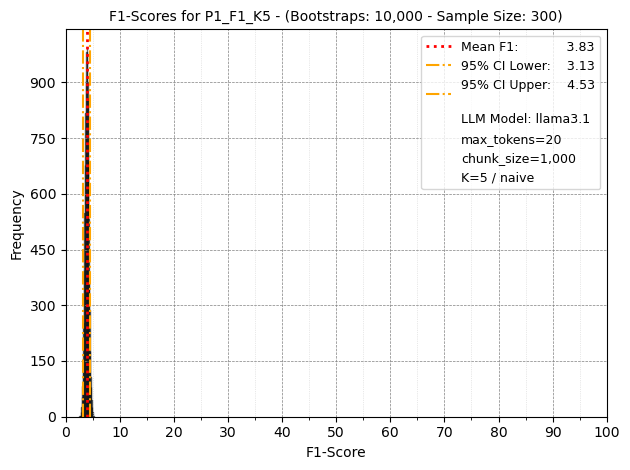

============= Get RAGAS metrics for P1_F1_K5 =============

Will now persist the experiment configuration for P1_F1_K5...
Persisting the experiment config done...

================== Execution times (in seconds): ==================================

Total execution time in Minutes: 8.54


In [34]:
#for VECTOR_STORE_TOP_K in [2, 3, 5, 6, 8, 12]:
start_timestamp_str = get_timestamp_as_string()
results_folder_name = create_results_folder(start_timestamp_str)

# Loop through all experiments and execute them one by one if they are included

#for index, row in df_experiments.iterrows():
for row in [current_experiment]:
    # if not RUN_ALL_EXPERIMENTS and not experiments_include[row["name"]]:
    #     continue

    sample_ldict = sample_ldicts[row["sample_ldicts_idx"]]
    experiment_name = row["name"]
    query_prompt_idx = row["query_prompt_idx"]
    context_needed = row["context_needed"]
    hyde_context_needed = row["hyde_context_needed"]
    suppress_answers = row["suppress_answers"]
    
    # print(f"sample_ldict: {sample_ldict}")
    print(f"experiment_name: {experiment_name}")
    print(f"query_prompt_idx: {query_prompt_idx}")
    print(f"context_needed: {context_needed}")
    print(f"hyde_context_needed: {hyde_context_needed}")
    print(f"suppress_answers: {suppress_answers}")
    
    run_experiment(sample_ldict, start_timestamp_str, experiment_name, query_prompt_idx,
                context_needed, hyde_context_needed, suppress_answers)

print(f"\n================== Execution times (in seconds): ==================================\n")
df_execution_times = pd.DataFrame(execution_times_l, 
                                columns=['experiment_name', 'execution_time', 'sample_size', 'bootstrap_n'])

pd.options.display.float_format = "{:.2f}".format
df_execution_times.head(100)              

print(f"Total execution time in Minutes: {round(sum(df_execution_times['execution_time']) / 60, 2)}")

In [35]:
# Reset the display format for floats
pd.reset_option('display.float_format')

In [36]:
print(f"Total execution time in Minutes: {round(sum(df_execution_times['execution_time']) / 60, 2)}")

Total execution time in Minutes: 8.54


In [37]:
ldict_qas_for_boostrapping_sample

#ldict_qas_for_boostrapping_sample
#ldict_qas_for_hyde_bootstrapping_sample
#ldict_qas_for_boostrapping_sample_semantic

[{'qid': '5ad4d2d65b96ef001a10a1fc',
  'question': 'What do B cells help T cells produce?',
  'question_context': 'A B cell identifies pathogens when antibodies on its surface bind to a specific foreign antigen. This antigen/antibody complex is taken up by the B cell and processed by proteolysis into peptides. The B cell then displays these antigenic peptides on its surface MHC class II molecules. This combination of MHC and antigen attracts a matching helper T cell, which releases lymphokines and activates the B cell. As the activated B cell then begins to divide, its offspring (plasma cells) secrete millions of copies of the antibody that recognizes this antigen. These antibodies circulate in blood plasma and lymph, bind to pathogens expressing the antigen and mark them for destruction by complement activation or for uptake and destruction by phagocytes. Antibodies can also neutralize challenges directly, by binding to bacterial toxins or by interfering with the receptors that viruse

In [38]:
# current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]

# print(current_query_prompt.template)
